In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HF_HOME"] = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/.cache/huggingface"

In [ ]:
from PIL import Image

import torch
import sys
import os

from patch import patch

from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.loaders import UNet2DConditionLoadersMixin, PeftAdapterMixin, FromSingleFileMixin
from pipeline.pipeline_stable_diffusion_joint_control import StableDiffusionPipelineJointControl
import torchvision.transforms as T
from safetensors import safe_open
from diffusers import StableDiffusionInpaintPipeline
from diffusers.utils import load_image, make_image_grid
from utils.dataset import process_frames
from utils.gaussian_2d import get_guassian_2d_rand_mask
from utils.util import blip_cap
import random
import numpy as np

seed = 12345

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


cond_x = False

image_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/House.jpg"
depth_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/House_depth.png"
if cond_x:
    input_path = image_path
else:
    input_path = depth_path

pipeline = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting",
                                                      safety_checker=None, 
                                                      torch_dtype=torch.float16).to("cuda")

# depth_lora_path = "/data/juicefs_sharing_data/11162591/code/lxr/svd-train/output_depth_lora/checkpoint-17000"
# pipeline.load_lora_weights(depth_lora_path, adapter_name="default")

checkpoint_dir = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/output_dir/output_mask_depth_lora/checkpoint-5000"

if not cond_x:
    mask_depth_lora_path = os.path.join(checkpoint_dir, "y_lora")
    pipeline.load_lora_weights(mask_depth_lora_path, adapter_name = "mask_depth_lora")

# state_dict = {}
# with safe_open("/data/juicefs_sharing_data/11162591/code/lxr/svd-train/output_depth_lora_rank64/checkpoint-2500/model.safetensors", framework="pt", device=0) as f:
#     for k in f.keys():
#         state_dict[k] = f.get_tensor(k)
# pipeline.unet.load_state_dict(state_dict)

pipeline = pipeline.to("cuda").to(torch.float16)

meta_data_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/readout_guidance/readout_training/data/metadata.jsonl"
import json
with open(meta_data_path, "r") as f:
    lines = list(f)
    lines = [json.loads(line) for line in lines]


use_noise_lora = False

cond_id = 1428
cond_image_name = lines[cond_id]["original_image"] if cond_x else lines[cond_id]["file_name"]
prompt = lines[cond_id]["text"]

depth_root = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/readout_guidance/readout_training/data/pseudo_labels/PascalVOC/depth"
depth_path = os.path.join(depth_root, cond_image_name)


In [ ]:

if input_path is not None:
    # depth_path = input_path
    depth_image = Image.open(input_path)
    # a = Image.open(input_path)
    if depth_image.mode == "I":
        depth_tensor = T.ToTensor()(depth_image)
        depth_tensor = (depth_tensor - depth_tensor.min()) / (depth_tensor.max() - depth_tensor.min())
        depth_image = T.ToPILImage()(depth_tensor)
    depth_image = depth_image.convert("RGB")
    raw_image  = Image.open(image_path).convert("RGB")
    prompt = blip_cap([depth_image])[0]
    # prompt = "a house"
else:
    depth_image = Image.open(depth_path).convert("RGB")

print(f"Load cond image from {depth_path}")

# depth_image = T.Resize(512)(depth_image)
# depth_image = T.CenterCrop(512)(depth_image)

# depth_image = T.ToTensor()(depth_image).to("cuda").to(torch.float16)
# height, width = depth_image.shape[-2:]

batch_size = 4
# depth_images = torch.stack([depth_image] * batch_size)

# depth_images = (depth_images - 0.5) / 0.5
# depth_latents = pipeline.vae.encode(depth_images).latent_dist.sample()
# depth_latents = depth_latents * pipeline.vae.config.scaling_factor
# depth_latents = None
print(prompt)

# generator = torch.Generator(device=depth_latents.device)
# generator = generator.manual_seed(123)

# channel = 4


# torch.random.manual_seed(1111)
# latents = torch.randn(batch_size // 2, channel, height // 8, width // 8).to("cuda").to(torch.float16)
# latents = torch.cat([latents] * 2)

# if use_noise_lora:
#     torch.manual_seed(123)
#     fix_noise = torch.randn(4, 512, 512)
#     condition_noise = fix_noise[None,...,:depth_latents.shape[-2],:depth_latents.shape[-1]].expand_as(depth_latents)
#     cond_mask = torch.zeros_like(condition_noise).to(torch.bool)
#     cond_mask[..., depth_latents.shape[-2] // 2:,:depth_latents.shape[-1]] = 1
#     # cond_mask = 1
# else:
# condition_noise = latents


height, width = 512, 512
init_image = depth_image
init_image = process_frames([init_image], height, width)[0]
# height, width = image.height, image.width
# rand_mask = get_guassian_2d_rand_mask(grid_size, noise_patch_size * 8)
# rand_mask = rand_mask[None,None,:height,:width].expand(batch_size, 1, height. width)
# init_image = load_image("https://hf-mirror.com/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png")
height, width = init_image.height, init_image.width

patch_size = 1

rand_mask = get_guassian_2d_rand_mask((max(height, width) // 8 // patch_size) + 1, patch_size, thresh = 0)
rand_mask = rand_mask[None,:height // 8,:width // 8].expand(3, height // 8, width // 8).to(torch.float32)
mask_image = T.ToPILImage()(rand_mask)

mask_image_resize = process_frames([mask_image], height, width)[0]
# mask_image = load_image("https://hf-mirror.com/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint_mask.png")
# generator = torch.Generator("cuda").manual_seed(92)
# prompt = "concept art digital painting of an elven castle, inspired by lord of the rings, highly detailed, 8k"
# prompt = args.validation_prompt

# for _ in range(args.num_validation_images):
images = pipeline(
        [prompt] * batch_size,
        image = [init_image] * batch_size,
        mask_image = [mask_image] * batch_size,
        height = height,
        width = width,
        # num_inference_steps=30, 
        # generator=generator
    ).images
image_grid = make_image_grid([init_image, mask_image_resize, *images], rows=1, cols=2 + len(images))

expnum = 0
save_path = os.path.join(checkpoint_dir, "test_results")
if not os.path.exists(save_path):
    os.mkdir(save_path)

image_grid.save(os.path.join(save_path, f"depth_test_{expnum}.png"))



In [ ]:


# from PIL import Image
# from diffusers import AutoPipelineForText2Image
# import torch
# from patch import patch
# import os
# from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, StableDiffusionPipeline, UNet2DConditionModel
# from diffusers.loaders import UNet2DConditionLoadersMixin, PeftAdapterMixin, FromSingleFileMixin
# from pipeline.pipeline_stable_diffusion_joint_control import StableDiffusionPipelineJointControl
# import torchvision.transforms as T
# from safetensors import safe_open
# from utils.gaussian_2d import get_guassian_2d_rand_mask


from PIL import Image, ImageOps
from patch import patch
# from diffusers import AutoPipelineForText2Image
import torch
from diffusers import AutoencoderKL, DDPMScheduler, DiffusionPipeline, StableDiffusionPipeline, UNet2DConditionModel, DDIMScheduler
from diffusers.loaders import UNet2DConditionLoadersMixin, PeftAdapterMixin, FromSingleFileMixin
from pipeline.pipeline_stable_diffusion_joint_control import StableDiffusionPipelineJointControl
import torchvision.transforms as T
from safetensors import safe_open
from diffusers import StableDiffusionInpaintPipeline
from diffusers.utils import load_image, make_image_grid
from utils.dataset import process_frames
from utils.gaussian_2d import get_guassian_2d_rand_mask
from utils.util import blip_cap
import random
import numpy as np

In [ ]:
use_noise_lora = False

model_id = "runwayml/stable-diffusion-inpainting"
# model_id = "/root/data/juicefs_sharing_data/11162591/code/models/runwayml/stable-diffusion-v1-5"

pipeline = StableDiffusionInpaintPipeline.from_pretrained(model_id,
                                                      safety_checker=None, 
                                                      torch_dtype=torch.float16).to("cuda")

In [ ]:
pipeline.scheduler, DDIMScheduler.from_config(pipeline2.scheduler.config), pipe.scheduler

In [ ]:
pipeline2 = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",
                                                      safety_checker=None, 
                                                      torch_dtype=torch.float16).to("cuda")

In [ ]:
depth_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/House_midas_depth.png"
depth_image = Image.open(depth_path).convert("RGB")
depth_tensor = T.ToTensor()(depth_image).to(torch.float16).to("cuda")
depth_tensor = depth_tensor * 2 - 1
depth_tensor = depth_tensor.unsqueeze(0)
depth_latents = pipeline.vae.encode(depth_tensor).latent_dist.sample() * pipeline.vae.config.scaling_factor
recon_depth_tensor = pipeline.vae.decode(
    depth_latents  / pipeline.vae.config.scaling_factor, return_dict=False
)[0] 
recon_depth_tensor = recon_depth_tensor.clamp(min = -1, max = 1)
recon_depth_image = T.ToPILImage()((recon_depth_tensor[0] + 1.) / 2.)
recon_depth_image

In [ ]:
patch.apply_patch(pipeline.unet)
patch.initialize_joint_layers(pipeline.unet)

# y_lora_path = "/data/juicefs_sharing_data/11162591/code/lxr/svd-train/output_depth_lora/pytorch_lora_weights.safetensors"
# pipeline.load_lora_weights(y_lora_path, adapter_name="y_lora")

# load attention processors
# output_path = "output_lora_joint_depth_image_joint_randt/checkpoint-10500"
# output_path = "output_lora_joint_depth_image_jointfix/checkpoint-5000"

# output_path = "/data/juicefs_sharing_data/11162591/code/lxr/svd-train/output_lora_joint_depth_image_clean_cond"
# output_path = "output_lora_joint_depth_image_clean_cond/checkpoint-5000"
output_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/output_dir/output_mask_depth_lora_joint"
y_lora_path = os.path.join(output_path, "y_lora")
pipeline.load_lora_weights(y_lora_path, adapter_name="y_lora")

for lora_name in ["xy_lora", "yx_lora"]:
    save_dir = os.path.join(output_path, f"{lora_name}")
    # lora_state_dict, lora_network_alphas = StableDiffusionPipeline.lora_state_dict(save_dir)
    # StableDiffusionPipeline.load_lora_into_unet(lora_state_dict, lora_network_alphas, unet = pipeline.unet, adapter_name = lora_name)
    pipeline.load_lora_weights(save_dir, adapter_name=lora_name)

# state_dict = torch.load(os.path.join(output_path, "model.safetensors"), map_location="cpu")

# rec_txt1 = open('output_lora_joint_depth_image_clean_cond1.txt', 'w')

# for name, para in pipeline.unet.named_parameters():
#     rec_txt1.write(f'{name}\n')

# rec_txt1.close()

state_dict = {}
model_path = os.path.join(output_path, "model.safetensors")
if os.path.exists(model_path):
    with safe_open(model_path, framework="pt", device=0) as f:
        for k in f.keys():
            state_dict[k] = f.get_tensor(k)
    pipeline.unet.load_state_dict(state_dict)
else:
    state_dict_dir = os.path.join(output_path, "model.pth")
    state_dict = torch.load(state_dict_dir)
    pipeline.unet.load_state_dict(state_dict, strict = False)


# rec_txt1 = open('output_lora_joint_depth_image_clean_cond2.txt', 'w')

# for name, para in pipeline.unet.named_parameters():
#     rec_txt1.write(f'{name}\n')

# rec_txt1.close()



active_adapters = ["xy_lora", "yx_lora", "y_lora"]

pipeline.set_adapters(active_adapters)
patch.hack_lora_forward(pipeline.unet)
patch.set_patch_lora_mask(pipeline.unet, "y_lora", [0,1,0,1])
patch.set_patch_lora_mask(pipeline.unet, "yx_lora", [0,1,0,1])
patch.set_patch_lora_mask(pipeline.unet, "xy_lora", [1,0,1,0])

pipeline = pipeline.to("cuda").to(torch.float16)


image_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/room.jpg"
depth_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/room_depth.jpg"


# depth_path = input_path
raw_image = Image.open(image_path)
depth_image = Image.open(depth_path)
# a = Image.open(input_path)
if depth_image.mode == "I":
    depth_tensor = T.ToTensor()(depth_image)
    depth_tensor = 1 - (depth_tensor - depth_tensor.min()) / (depth_tensor.max() - depth_tensor.min())
    
    depth_image = T.ToPILImage()(depth_tensor)

depth_image = depth_image.convert("RGB")

prompt = blip_cap([raw_image])[0]

print(f"Load cond image from {image_path}, cond depth from {depth_path}")

batch_size = 2

print(prompt)

height, width = 512, 512
patch_size = 1


seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

generator = torch.Generator(device="cuda")
generator = generator.manual_seed(seed)
height, width = 512, 512
init_images = [raw_image,  depth_image]
init_images = process_frames(init_images, height, width)
init_images = [init_images[0]] * (batch_size // 2) + [init_images[1]] * (batch_size // 2)
# height, width = image.height, image.width
# rand_mask = get_guassian_2d_rand_mask(grid_size, noise_patch_size * 8)
# rand_mask = rand_mask[None,None,:height,:width].expand(batch_size, 1, height. width)
# init_image = load_image("https://hf-mirror.com/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png")
height, width = init_images[0].height, init_images[0].width
rand_mask = [get_guassian_2d_rand_mask((max(height, width) // 8 // patch_size) + 1, patch_size, thresh = 0) for i in range(batch_size)]
rand_mask = torch.stack(rand_mask, dim = 0)
rand_mask = rand_mask[:, None,:height // 8,:width // 8].expand(batch_size, 3, height // 8, width // 8).to(torch.float32)

rand_mask[:,:,:,rand_mask.shape[-1] // 2:] = 0.0
rand_mask[:,:,:,:rand_mask.shape[-1] // 2] = 1.0

# rand_mask[:] = 0

rand_mask[batch_size // 2:] = 1 - rand_mask[:batch_size // 2]
mask_images = [T.ToPILImage()(mask) for mask in rand_mask]
# mask_image = load_image("https://hf-mirror.com/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint_mask.png")
# generator = torch.Generator("cuda").manual_seed(92)
# prompt = "concept art digital painting of an elven castle, inspired by lord of the rings, highly detailed, 8k"


images = pipeline(
        [prompt] * batch_size,
        image = init_images,
        mask_image = mask_images,
        height = height,
        width = width,
        # num_inference_steps=30, 
        generator=generator
    ).images

mask_images_upscale = process_frames(mask_images, height, width)

images_with_mask = []
for im, miu in zip(images, mask_images_upscale):
    # Create a mask with transparency
    inverted_mask = ImageOps.invert(miu.convert("L"))
    mask_with_alpha = Image.new('RGBA', inverted_mask.size)
    mask_with_alpha.paste((255, 0, 0, 128), (0, 0), inverted_mask)  # Red color with 50% opacity

    # Composite the overlay with the original image
    image_with_mask = Image.alpha_composite(im.convert('RGBA'), mask_with_alpha)
    images_with_mask.append(image_with_mask)

image_grid = make_image_grid([*init_images, *mask_images_upscale, *images, *images_with_mask], rows=4, cols=batch_size)

exp_name = os.path.basename(image_path).split(".")[0]
save_path = os.path.join(output_path, "test_results")
if not os.path.exists(save_path):
    os.mkdir(save_path)

image_grid.save(os.path.join(save_path, f"{exp_name}.png"))

In [ ]:
depth_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/room_depth.jpg"
depth_image = Image.open(depth_path)
depth_image = depth_image.convert("RGB")
depth_tensor = T.ToTensor()(depth_image)
depth_tensor

In [ ]:
depth_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/House_depth.png"
depth_image = Image.open(depth_path)
# a = Image.open(input_path)
if depth_image.mode == "I":
    depth_tensor = T.ToTensor()(depth_image)
    depth_tensor = 1 - (depth_tensor - depth_tensor.min()) / (depth_tensor.max() - depth_tensor.min())
    
    depth_image = T.ToPILImage()(depth_tensor)
output_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/House_depth.png"
depth_image = depth_image.convert("RGB")
depth_image.save(output_path)

In [ ]:
import glob, os
import numpy as np
from PIL import Image
gray_depth_root = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/PascalVOC/VOC2012/depth_anything_v2_gray/"
color_depth_root = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/PascalVOC/VOC2012/depth_anything_v2_color/"
image_root = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/PascalVOC/VOC2012/JPEGImages/"
depth_paths = glob.glob(os.path.join(gray_depth_root, "*.jpg"))

depth_arr = np.array(depth_paths)
rand_num = 5
rand_depths = np.random.choice(depth_arr, size = rand_num, replace=False)

output_root = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs"
for path in rand_depths:
    gray_depth_image = Image.open(path)
    raw_image = Image.open(os.path.join(image_root, os.path.basename(path)))
    color_depth_image = Image.open(os.path.join(color_depth_root, os.path.basename(path)))
    gray_depth_image.save(os.path.join(output_root, "gray_depth" + os.path.basename(path)))
    color_depth_image.save(os.path.join(output_root, "color_depth" + os.path.basename(path)))
    raw_image.save(os.path.join(output_root, "image" + os.path.basename(path)))

In [ ]:
import torch

save_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/output_dir/output_mask_depth_lora/model.pth"
#save_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/output_dir/output_mask_depth_lora_joint_freezey/model.pth"
state_dict = torch.load(save_path)

In [ ]:
state_dict = pipeline.unet.state_dict()

In [ ]:
total_params = 0
for param_tensor in state_dict.values():
    total_params += param_tensor.numel()
total_params / 1000 / 1000

In [ ]:
# import torch.nn.functional as F


# def dilate(im_tensor, kernel_size = 3):
#     dtype = im_tensor.dtype
#     kernel = np.ones([kernel_size, kernel_size])
#     kernel_tensor = torch.Tensor(np.expand_dims(np.expand_dims(kernel, 0), 0))
#     result = torch.clamp(torch.nn.functional.conv2d(im_tensor, kernel_tensor, padding=(kernel_size // 2, kernel_size // 2)), 0, 1).int()
#     return result.to(dtype)

# def blur(im_tensor, kernel_size = 3):
#     kernel = np.ones([kernel_size, kernel_size]) / (kernel_size ** 2)
#     kernel_tensor = torch.Tensor(np.expand_dims(np.expand_dims(kernel, 0), 0))
#     result = torch.clamp(torch.nn.functional.conv2d(im_tensor, kernel_tensor, padding=(kernel_size // 2, kernel_size // 2)), 0, 1)
#     return result

# def rand_mask_test(batch_size, grid_size, mask_size, thresh = None, noise_patch_size = 1, smooth = True, blur_kernel = 5, dilate_kernel = 7, dtype = torch.float32):
#     # rand_grid_size = torch.randint(grid_size_range[0], grid_size_range[1], (bsz,))
#     grid_sizes = [grid_size] * batch_size
#     rand_masks = [get_guassian_2d_rand_mask(gs, noise_patch_size, thresh = thresh).view(1,1,grid_size, grid_size).to(dtype) for gs in grid_sizes]

#     # rand_masks = [F.interpolate(rand_mask, size = mask_size, mode="bilinear") for rand_mask in rand_masks]
#     # kernel_sizes = [1,3,5,7,9,11,13,15,17]
#     # rand_masks[0] = blur(rand_masks[0].view(1,1,*rand_masks[0].shape), 5)
#     # rand_masks[0] = rand_masks[0].view(1,1,*rand_masks[0].shape)
#     # rand_masks = [dilate(rand_masks[0], kernel_size) for kernel_size in kernel_sizes]
#     rand_masks = torch.cat(rand_masks, dim = 0)
#     if smooth:
#         rand_masks = dilate(blur(rand_masks, blur_kernel), dilate_kernel)
#         one_minus_rand_masks = 1 - rand_masks
#         rand_tensor = (torch.rand(batch_size) < 0.5).view(-1, 1, 1, 1)
#         rand_masks = torch.where(rand_tensor, rand_masks, one_minus_rand_masks) 
#         # rand_masks = blur(dilate(rand_masks, dilate_kernel), blur_kernel).int().to(torch.float32)
        
    

#     # rand_masks = rand_masks.expand(bsz, 1, *mask_size)
#     return rand_masks

from utils.gaussian_2d import get_rand_masks, set_smooth_kernel
set_smooth_kernel(blur_ks = 5, dilate_ks = 5)

rand_masks = get_rand_masks(9, 64, (64, 64))
rand_masks = [T.ToPILImage()(rand_mask) for rand_mask in rand_masks]
rand_mask_grid = make_image_grid(rand_masks, rows = 3, cols = 3)
# print(rand_grid_size)
rand_mask_grid

In [ ]:

import sys
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HF_HOME"] = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/.cache/huggingface"

from transformers import pipeline
from PIL import Image
import requests

# load pipe
pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Large-hf")


In [ ]:

# load image
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/House.jpg")

# inference
res = pipe(image)
image.height, image.width

In [ ]:
res["predicted_depth"].shape

In [ ]:
import matplotlib
import torchvision.transforms as T
import torch
import numpy as np
depth_tensor = res["predicted_depth"]
# depth_tensor = (depth_tensor - depth_tensor.min()) / (depth_tensor.max() - depth_tensor.min()) * 255.0

depth_tensor = torch.nn.functional.interpolate(
    depth_tensor.unsqueeze(1),
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)[0]

depth_tensor = depth_tensor  / depth_tensor.max() * 255.0

depth_tensor = depth_tensor.to(torch.uint8)

cmap = matplotlib.colormaps.get_cmap('Spectral_r')
colored_depth = (cmap(depth_tensor[0])[:, :, :3] * 255).astype(np.uint8)

gray_depth = T.ToPILImage()(depth_tensor)

color_depth = Image.fromarray(colored_depth)
depth_tensor.shape, colored_depth.shape

In [ ]:
(cmap(depth_tensor[0]) * 255).astype(np.uint8)
#https://stackoverflow.com/questions/45177154/how-to-decode-color-mapping-in-matplotlibs-colormap

In [ ]:
image.size[::-1]

In [ ]:
import torchvision.transforms.v2 as transforms
from PIL import Image



train_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'

x_image = Image.open(requests.get(url, stream=True).raw)
y_image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
x_image_trans, y_image_trans = train_transforms(x_image, y_image)
print([x_image_trans.min(), x_image_trans.max()], [y_image_trans.min(), y_image_trans.max()])

In [ ]:
y_image_trans.min()

In [ ]:
ToDoList = {
    "Image fusion",
    "Ablations: no encoder joint cross attention, postconv to postscale, 64 or 32"
    "Camera Move",
    "Marigold dataset",
    "caption (https://github.com/pharmapsychotic/clip-interrogator)",
    "Video frame joint generation",
    "how to map pixel to point clouds"
}

In [ ]:
import torchvision.transforms.v2 as transforms
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'

x_image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
# def random_train_transforms(hw_logratio_range = [np.log(9 / 16), np.log(16 / 9)]):
import random 
import numpy as np
hw_logratio_range = [np.log(0.66666666667), np.log(1.5)]
total_pixels = 512 * 512
hw_logratio = random.uniform(*hw_logratio_range)
# hw_logratio = np.log(1.5)
hw_ratio = np.e ** (hw_logratio)
# hw_ratio =  0.5
width = int(np.sqrt(total_pixels / hw_ratio) / 8 + 0.5) * 8
height = int(total_pixels // width / 8 + 0.5) * 8
# random_sizes = [(512, 512), (576, 448), (576, 384), (448, 576), (384, 576), (640, 448), (448, 640)]
# height, width = random.choice(random_sizes)


hw_ratio = height / width


print(height, width, hw_ratio, np.sqrt(width * height))

train_transforms = transforms.Compose(
    [   
        transforms.RandomResizedCrop(size = (height, width), scale = (0.5, 1.0), ratio = (1 / hw_ratio, 1 / hw_ratio))
        # transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
        # transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
        # transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
        # # transforms.ToTensor(),
        # transforms.ToImage(),
        # transforms.ToDtype(torch.float32, scale=True),
        # transforms.Normalize([0.5], [0.5]),
        # transforms.Normalize([0.5], [0.5]),
    ]
)


train_transforms(x_image)
    # return train_transforms


In [ ]:
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HF_HOME"] = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/.cache/huggingface"
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DDIMScheduler
import torch
from utils.util import load_scheduler

controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_seg", torch_dtype=torch.float16, use_safetensors=True)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
)

# pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

In [ ]:
# pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
load_scheduler(pipe, "ead")
pipe.scheduler

In [ ]:
from PIL import Image
from utils.dataset import process_frames
image = Image.open("/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/seg-room-gt.webp")
prompt = "best quality, extremely detailed, there is a living room with a couch, table, chairs and a television"
image = process_frames([image], h = 512, w = 512)[0]
output = pipe(
    prompt, image=image, guidance_scale=7.5, num_inference_steps=50, height = 512, width = 512, negative_prompt="longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"
).images

In [ ]:
# image = Image.open("/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/seg-table-gt.webp")
# process_frames([image], h = 512, w = 512)[0]
image

In [ ]:
from utils.gaussian_2d import get_rand_masks, set_smooth_kernel
import torchvision.transforms as T
height = width = 512
grid_size = max(height, width)
rand_masks = get_rand_masks(4, grid_size, noise_patch_size = 1, thresh = 0)
rand_masks = rand_masks[...,:height, :width]
mask_images = [T.ToPILImage()(mask) for mask in rand_masks]
mask_images[0]


In [ ]:
import torch
bsz = 32
latents = torch.ones([32,4,64,64])
zero_mask = torch.zeros_like(latents)
one_mask = torch.ones_like(latents)
condition = (torch.arange(bsz) < (bsz // 4)).view(-1, 1,1,1)
rand_mask = torch.where(condition, zero_mask, one_mask)


In [ ]:
rand_mask[8].sum()

In [ ]:
image.height, image.width

In [ ]:
import torch
from PIL import Image
import requests
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HF_HOME"] = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/.cache/huggingface"
from transformers import OneFormerProcessor, OneFormerModel
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
from PIL import Image
import requests
import torch

# load OneFormer fine-tuned on ADE20k for universal segmentation
processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny")
model = OneFormerForUniversalSegmentation.from_pretrained("shi-labs/oneformer_ade20k_swin_tiny")

url = (
    "https://hf-mirror.com/datasets/hf-internal-testing/fixtures_ade20k/resolve/main/ADE_val_00000001.jpg"
)
image = Image.open(requests.get(url, stream=True).raw)

# Semantic Segmentation
inputs = processor(image, ["semantic"], return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for semantic postprocessing
predicted_semantic_map = processor.post_process_semantic_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]
print(f"👉 Semantic Predictions Shape: {list(predicted_semantic_map.shape)}")

# Instance Segmentation
inputs = processor(image, ["instance"], return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for instance postprocessing
predicted_instance_map = processor.post_process_instance_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]["segmentation"]
print(f"👉 Instance Predictions Shape: {list(predicted_instance_map.shape)}")

# Panoptic Segmentation
inputs = processor(image, ["panoptic"], return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
# model predicts class_queries_logits of shape `(batch_size, num_queries)`
# and masks_queries_logits of shape `(batch_size, num_queries, height, width)`
class_queries_logits = outputs.class_queries_logits
masks_queries_logits = outputs.masks_queries_logits

# you can pass them to processor for panoptic postprocessing
predicted_panoptic_map = processor.post_process_panoptic_segmentation(
    outputs, target_sizes=[image.size[::-1]]
)[0]["segmentation"]
f"👉 Panoptic Predictions Shape: {list(predicted_panoptic_map.shape)}"

In [ ]:
predicted_panoptic_map
visualizer = Visualizer(image, metadata=self.metadata, instance_mode=ColorMode.IMAGE)
    predictions = self.predictor(image, task)
    panoptic_seg, segments_info = predictions["panoptic_seg"]
    vis_output['panoptic_inference'] = visualizer.draw_panoptic_seg_predictions(
    panoptic_seg.to(self.cpu_device), segments_info, alpha=0.7
)

In [ ]:
# from detectron2 import data
import os
import sys
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
os.environ["HF_HOME"] = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/.cache/huggingface"
sys.path.append("/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/ControlNet-v1-1-nightly")
from annotator.oneformer import OneformerCOCODetector, OneformerADE20kDetector

In [ ]:
from PIL import Image
import requests
import torch
url = (
    "https://hf-mirror.com/datasets/hf-internal-testing/fixtures_ade20k/resolve/main/ADE_val_00000001.jpg"
)
image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
image_arr2 = np.stack([image_arr] * 2, axis = 0)
output = preprocessor(image_arr2)

In [ ]:
import numpy as np
image_arr = np.array(image)
preprocessor = OneformerADE20kDetector()


In [ ]:
Image.fromarray(output)

In [ ]:
from PIL import Image, ImageDraw, ImageFilter

def create_feathered_circle(image_size, circle_radius, feather_radius):
    # Create a new image with a white background
    image = Image.new('L', image_size, 255)
    
    # Create a drawing context
    draw = ImageDraw.Draw(image)
    
    # Draw a solid black circle in the middle
    center = (image_size[0] // 2, image_size[1] // 2)
    draw.ellipse((center[0] - circle_radius, center[1] - circle_radius, 
                  center[0] + circle_radius, center[1] + circle_radius), fill=0)
    
    # Apply a Gaussian blur to create the feathering effect
    image = image.filter(ImageFilter.GaussianBlur(feather_radius))
    
    return image

# Parameters
image_size = (512, 512)  # Size of the image
circle_radius = 200      # Radius of the black circle
feather_radius = 25      # Radius for the feather effect

# Create the feathered circle image
feathered_circle_image = create_feathered_circle(image_size, circle_radius, feather_radius)

# Save the image
# feathered_circle_image.save('feathered_circle.png')
output_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/feathered_circle_mask_large.jpg"
feathered_circle_image.save(output_path)


In [ ]:
import numpy as np
from PIL import Image
a = np.zeros([512,512])
b = np.linspace(0, 1, 512).reshape(1, 512)
a += b
print(a.shape)
a = (a * 255.).astype(np.uint8)

mask = Image.fromarray(a)
mask.save("/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/feathered_horizontal_mask.jpg")
a

In [ ]:
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, UniPCMultistepScheduler, StableDiffusionControlNetPipeline
import torch
# controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16, use_safetensors=True)
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11f1p_sd15_depth", torch_dtype=torch.float16, use_safetensors=True)
# pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
#     "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
# )
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
).to("cuda")

In [ ]:
from PIL import Image
import torchvision.transforms as T
from diffusers.utils import make_image_grid
image_raw = Image.open("/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/PascalVOC/VOC2012/depth_anything_v2_color/2007_003267.jpg")
image = T.ToTensor()(image_raw).to(torch.float16).to("cuda")
image = image * 2 - 1
image_latents = pipe.vae.encode(image.unsqueeze(0)).latent_dist.sample()
image = pipe.vae.decode(image_latents).sample[0]
image = ((image + 1) / 2).clip(min = -1, max = 1)
image = T.ToPILImage()(image)
make_image_grid([image, image_raw], rows = 1, cols = 2)

In [ ]:
from diffusers.utils import load_image, make_image_grid

init_image = load_image(
    # "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/football.jpg"
    # "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/flower.jpg"
    "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/House.jpg"
)
init_image = init_image.resize((512, 512))

mask_image = load_image(
    # "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/football-mask-invert.webp"
    "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/flower-mask-invert.webp"
)
mask_image = mask_image.resize((512, 512))
make_image_grid([init_image, mask_image], rows=1, cols=2)

import numpy as np
import torch

def make_inpaint_condition(image, image_mask):
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

    assert image.shape[0:1] == image_mask.shape[0:1]
    image[image_mask > 0.5] = -1.0  # set as masked pixel
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image

# control_image = make_inpaint_condition(init_image, mask_image)
control_image = load_image(
    # "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/floor-depth-gray.png"
    # "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/table-depth-gray.png"
    "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/House-depth-color.webp"
)

from utils.dataset import process_frames

control_image = process_frames([control_image], h = 512, w = 512)[0]

from utils.util import load_scheduler
# pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
load_scheduler(pipe, "ead")
pipe.enable_model_cpu_offload()

output = pipe(
    # "best quality, extremely detailed, a football lying on the floor of a living room",
    # "best quality, extremely detailed, a football lying on the table in a room",
    "best quality, extremely detailed, there is a digital image of a man holding a tennis racket",
    negative_prompt="longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality",
    num_inference_steps=50,
    guidance_scale=7.5,
    strength=1.0,
    # eta=1.0,
    image=init_image,
    # mask_image=mask_image,
    control_image=control_image,
    height = 512,
    width = 512
).images[0]
make_image_grid([init_image, mask_image, control_image, output], rows=2, cols=2)

In [ ]:
from omegaconf import OmegaConf


from utils.dataset import TrackDataset
from utils import train_helpers
import numpy as np
import pdb
from PIL import Image

config_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/train_models/train_configs/track_dataset.yaml"

config = OmegaConf.load(config_path)
config = OmegaConf.to_container(config, resolve=True)
# train_dataset, train_dataloader = get_correspondence_loader(config, config["train_file"], True)

dataset = TrackDataset(**config)
it = iter(dataset)


In [ ]:
"goat" in st

In [ ]:
st = set([d["source"].split("/")[0] for d in dataset.data])
print(len(st))

In [ ]:
a = next(it)

In [ ]:
a["source_frame"][0].save("/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/example_inputs/riding-source.png")
a["target_frame"][0].save("/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/example_inputs/riding-target.png")

In [ ]:
a

In [ ]:
a["source_frame"][0]

In [ ]:
a["target_frame"][0]

In [ ]:
from PIL import Image
exp_name = "man-crocodile"
source_image_path = f"/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/readout_guidance/data/drag/real/{exp_name}/source.png"
source_image_pil = Image.open(source_image_path)

import numpy as np
tracks = np.load(f"/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/readout_guidance/data/drag/real/{exp_name}/tracks_mouth-close.npy")

In [ ]:
def draw_tracks_target(target_image_pil, tracks, line_width = 5, arrow_width = 5, alpha = 0.5, color = (0, 255, 0)):
    source_points = tracks[0,...]
    target_points = tracks[1,...]
    target_image_pil_track = target_image_pil 

    for src_point, tgt_point in zip(source_points, target_points):
        # target_image_pil_points = add_transparent_point(target_image_pil_points.convert("RGBA"), tgt_point, 5, (0, 255,0), 127) 
        # print(src_point, tgt_point)
        print(tgt_point, src_point)
        target_image_pil_track = draw_arrow(target_image_pil_track.convert("RGBA"), 
            tgt_point, src_point, line_width, color, int(alpha * 255), arrow_width)

    return target_image_pil_track
draw_tracks_target(source_image_pil, tracks[0,::-1]).save(f"/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/example_inputs/drag_{exp_name}.png")

In [ ]:
from PIL import Image
import os
from importlib import reload
import random
reload(train_helpers)
# from utils import train_helpers

idx = random.randint(0, len(dataset) - 1)

item = dataset.data[idx]
print(item)
# pdb.set_trace()
source_image_pil = Image.open(os.path.join(dataset.bucket_root, dataset.image_root, item["source"]))
target_image_pil = Image.open(os.path.join(dataset.bucket_root, dataset.image_root, item["target"]))
source = np.array(source_image_pil)
target = np.array(target_image_pil)

i, j = train_helpers.get_frame_idx(item["source"]), train_helpers.get_frame_idx(item["target"])

# Load point tracks
video_name = item["source"].split("/")[0]
tracks, visibles = train_helpers.open_points(i, j, video_name, dataset.max_frame_idx, dataset.bucket_root, dataset.points_root)
mask = train_helpers.open_mask(i, video_name, dataset.bucket_root, dataset.mask_root)
if random.random() < 0.5:
    mask = None
height, width, _ = source.shape
print(tracks.shape)
tracks_full = train_helpers.filter_tracks(tracks, width, height, mask, dataset.num_points)
print(tracks_full.shape)
# visibles = visibles[:, valid_idxs]
# print(tracks_full.shape)

import random
def sample_track(tracks, visibles = None, mask = None, num_samples = 5, reg = 0.1):
    # print(tracks)
    track_norm = np.linalg.norm(tracks[0] - tracks[1], axis=-1)
    if visibles is not None:
        track_norm[~visibles] = 0
    track_norm = (track_norm - track_norm.mean()) / (track_norm.std() + 1e-6)
    # print(sorted(track_norm, reverse =True)[:10])
    # track_prob = track_norm / sum(track_norm)
    # print(track_norm)
    track_norm -= np.max(track_norm)
    # print(track_norm)
    track_prob = (np.exp(track_norm)) / sum(np.exp(track_norm))
    # print(track_prob)
    track_prob = (track_prob + (reg / len(track_prob))) / (1 + reg)
    # print(track_prob)
    
    # print(sorted(track_prob, reverse =True)[:10])
    # track_prob[:] = 0
    # track_prob[0] = 1
    # print(track_prob.shape)
    num_samples = min(tracks.shape[1], num_samples)
    sample_idx = np.random.choice(tracks.shape[1], num_samples, replace=False, p = track_prob)
    return sample_idx
# visible_and = np.logical_and(visibles[0], visibles[1])
sample_idx = [sample_track(tracks_full, num_samples=random.randint(1, 10)) for i in range(1)]
sample_idx = np.concatenate(sample_idx)
tracks = tracks_full[:, sample_idx, :]


from PIL import Image, ImageDraw, ImageFilter
import torch
def draw_arrow(image, start_point, end_point, arrow_width, arrow_color, arrow_alpha, arrowhead_size = 5):
    

    # Create a temporary image for drawing the arrow with transparency
    temp_image = Image.new('RGBA', image.size, (255, 255, 255, 0))
    temp_image = temp_image.resize(image.size)
    temp_draw = ImageDraw.Draw(temp_image)

    # Draw the arrow body
    temp_draw.line([*start_point, *end_point], fill=arrow_color + (arrow_alpha,), width=arrow_width)

    # Calculate the arrowhead
    # arrowhead_size = 15  # Size of the arrowhead
    direction = ((end_point[0] - start_point[0]), (end_point[1] - start_point[1]))  # Direction of the arrow
    direction_magnitude = (direction[0]**2 + direction[1]**2)**0.5  # Magnitude of the direction vector
    normalized_direction = (direction[0]/direction_magnitude, direction[1]/direction_magnitude)  # Normalized direction vector

    # Calculate the arrowhead points
    left_arrowhead_point = (
        end_point[0] - arrowhead_size * normalized_direction[1],
        end_point[1] + arrowhead_size * normalized_direction[0]
    )
    right_arrowhead_point = (
        end_point[0] + arrowhead_size * normalized_direction[1],
        end_point[1] - arrowhead_size * normalized_direction[0]
    )

    top_arrowhead_point = (
        end_point[0] + arrowhead_size * normalized_direction[0],
        end_point[1] + arrowhead_size * normalized_direction[1]
    )

    # Draw the arrowhead
    temp_draw.polygon([*top_arrowhead_point, *left_arrowhead_point, *right_arrowhead_point], fill=arrow_color + (arrow_alpha,))

    # Combine the temporary image with the original image
    combined = Image.alpha_composite(image, temp_image)

    return combined

def add_transparent_point(image, position, point_radius, color, alpha):
    # Create a transparent layer
    overlay = Image.new('RGBA', image.size, (255, 255, 255, 0))
    draw = ImageDraw.Draw(overlay)
    
    # Draw a semi-transparent point
    draw.ellipse((position[0] - point_radius, position[1] - point_radius, 
                  position[0] + point_radius, position[1] + point_radius), fill=(color[0], color[1], color[2], alpha))
    
    # Composite the original image with the transparent overlay
    image = Image.alpha_composite(image, overlay)
    
    return image

def draw_tracks(source_image_pil, target_image_pil, tracks):
    source_points = torch.tensor(tracks[0,...])
    target_points = torch.tensor(tracks[1,...])
    source_image_pil_points = source_image_pil
    target_image_pil_points = target_image_pil
    for src_point, tgt_point in zip(source_points, target_points):
        # source_image_pil_points = add_transparent_point(source_image_pil_points.convert("RGBA"), src_point, 5, (0, 255,0), 127) 
        # print(src_point, tgt_point)
        source_image_pil_points = draw_arrow(source_image_pil_points.convert("RGBA"), src_point.numpy(), tgt_point.numpy(), 5, (0, 255,0), 255) 

    for src_point, tgt_point in zip(source_points, target_points):
        # target_image_pil_points = add_transparent_point(target_image_pil_points.convert("RGBA"), tgt_point, 5, (0, 255,0), 127) 
        # print(src_point, tgt_point)
        target_image_pil_points = draw_arrow(target_image_pil_points.convert("RGBA"), tgt_point.numpy(), src_point.numpy(), 5, (0, 255,0), 127) 

def draw_tracks_target(target_image_pil, tracks, line_width = 5, arrow_width = 5, alpha = 0.5, color = (0, 255, 0)):
    source_points = tracks[0,...]
    target_points = tracks[1,...]
    target_image_pil_track = target_image_pil 

    for src_point, tgt_point in zip(source_points, target_points):
        # target_image_pil_points = add_transparent_point(target_image_pil_points.convert("RGBA"), tgt_point, 5, (0, 255,0), 127) 
        # print(src_point, tgt_point)
        target_image_pil_track = draw_arrow(target_image_pil.convert("RGBA"), 
            tgt_point.numpy(), src_point.numpy(), line_width, color, int(alpha * 255), arrow_width)

    return target_image_pil_track
    



width1, height1 = source_image_pil_points.size
width2, height2 = target_image_pil_points.size

# Determine dimensions of the combined image
total_width = width1 + width2 * 2
max_height = max(height1, height2)

# Create a new blank image with the determined dimensions
combined_image = Image.new('RGB', (total_width, max_height))

# Paste the first image at (0, 0)
combined_image.paste(source_image_pil_points, (0, 0))


# Paste the second image at (width1, 0)
combined_image.paste(target_image_pil_points, (width1, 0))
if mask is not None:
    print("merge mask")
    combined_image.paste(mask, (width1 + width2, 0))

# combined_image.paste(mask, (width1 + width2, 0))
combined_image

In [ ]:
from PIL import Image
import torchvision.transforms.v2 as T
import matplotlib
import torch
import numpy as np
image_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/inputs/example_inputs/snowman.png"
image = Image.open(image_path).convert("RGB")

to_tensor = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
])

depth_tensor = to_tensor(image)
cmap = matplotlib.colormaps.get_cmap('Spectral_r')

depth_tensor_flatten = depth_tensor.flatten()
depth_tensor_flatten = depth_tensor_flatten.sort().values
dlen = depth_tensor_flatten.shape[0]
print((depth_tensor_flatten == 1).sum() / dlen)

dmin, dmax = depth_tensor_flatten[int(dlen * 0.02)], depth_tensor_flatten[int(dlen * 0.98) - 1]
print(dmin, dmax)
print(depth_tensor_flatten.min(), depth_tensor_flatten.max())



depth_tensor = (depth_tensor - dmin) / (dmax - dmin) * 255.0

# depth_tensor[depth_tensor == 255] = 0
depth_tensor = depth_tensor.clamp(min = 0, max = 255)
print(depth_tensor.min(), depth_tensor.max())
depth_tensor = depth_tensor.to(torch.uint8)
color_depth_array = (cmap(depth_tensor[0])[:, :, :3] * 255).astype(np.uint8)
color_depth = Image.fromarray(color_depth_array)
color_depth.save(image_path.replace(".png", "_color.png"))

In [ ]:
import json
import os
input_root = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/annotate/annotations/"
input_file = "PascalVOC_val.json"
output_root = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/annotate/"

with open(os.path.join(output_root, input_file), "r") as f:
    a = json.load(f)

# b = [aa['source'] for aa in a] 
# with open(os.path.join(output_root, input_file), "w") as f:
#     json.dump(b, f)


In [ ]:
type(a)

In [ ]:
from datasets import load_dataset
dataset = load_dataset(
    "json",
    data_files="/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/PascalVOC/VOC2012/depth/val_dataset.json"
)

In [ ]:
next(iter(dataset["train"]))

In [ ]:
from PIL import Image
import os
import json
import numpy as np
import torch

dataset_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/PascalVOC/VOC2012/depth/val_dataset.json"
val_dataset = json.load(open(dataset_path))



image_paths = [line['original_image'] for line in val_dataset]

real_images = [Image.open(path).convert("RGB") for path in image_paths]

from torchvision.transforms import functional as F
import torchvision.transforms.v2 as transforms
from utils.dataset import process_frames

height, width = 512, 512

ToTensor = transforms.Compose(
    [
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
    ]
)


def preprocess_image(image):
    image = process_frames([image], height, width,  verbose = False, div = 8, rand_crop=False)[0]
    image = ToTensor(image)
    # return F.center_crop(image, (256, 256))
    return image


processed_real_images = torch.stack([preprocess_image(image) for image in real_images], dim = 0)
print(processed_real_images.shape)
# torch.Size([10, 3, 256, 256])

from glob import glob
generate_image_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/output_final/output_depth_gray_controlnet/eval"
generate_image_paths = [os.path.join(generate_image_path, line['file_name']) for line in val_dataset]

fake_images = [Image.open(path).convert("RGB") for path in generate_image_paths]
processed_fake_images = torch.stack([preprocess_image(image) for image in fake_images], dim = 0)
print(processed_real_images.shape)

processed_fake_images.min(), processed_fake_images.max()


from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(normalize=True)
fid.update(processed_real_images, real=True)
fid.update(processed_fake_images, real=False)

print(f"FID: {float(fid.compute())}")

prompt_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/annotate/PascalVOC_prompt.json"
with open(prompt_path, "r") as f:
    prompt_dict = json.load(f)
# image_paths = [line['original_image'] for line in val_dataset]
prompts = [prompt_dict[line['file_name']][0] for line in val_dataset]

from torchmetrics.functional.multimodal import clip_score
from functools import partial

clip_score_fn = partial(clip_score, model_name_or_path="openai/clip-vit-base-patch16")

def calculate_clip_score(images, prompts):
    images_int = (images * 255).to(torch.uint8)
    clip_score = clip_score_fn(images_int, prompts).detach()
    return round(float(clip_score), 4)


sd_clip_score = calculate_clip_score(processed_fake_images, prompts)
print(f"CLIP score: {sd_clip_score}")

import os
import numpy as np
import torch
import pytorch_lightning as pl
import torch.nn as nn
import clip
from PIL import Image, ImageFile
import pdb


class MLP(pl.LightningModule):
    def __init__(self, input_size, xcol='emb', ycol='avg_rating'):
        super().__init__()
        self.input_size = input_size
        self.xcol = xcol
        self.ycol = ycol
        self.layers = nn.Sequential(
            nn.Linear(self.input_size, 1024),
            #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            #nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64, 16),
            #nn.ReLU(),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        x = batch[self.xcol]
        y = batch[self.ycol].reshape(-1, 1)
        x_hat = self.layers(x)
        loss = F.mse_loss(x_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[self.xcol]
        y = batch[self.ycol].reshape(-1, 1)
        x_hat = self.layers(x)
        loss = F.mse_loss(x_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

def normalized(a, axis=-1, order=2):
    import numpy as np  # pylint: disable=import-outside-toplevel

    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2 == 0] = 1
    return a / np.expand_dims(l2, axis)

def load_models():
    model = MLP(768)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    s = torch.load("sac+logos+ava1-l14-linearMSE.pth", map_location=device)

    model.load_state_dict(s)
    model.to(device)
    model.eval()

    model2, preprocess = clip.load("ViT-L/14", device=device)

    model_dict = {}
    model_dict['classifier'] = model
    model_dict['clip_model'] = model2
    model_dict['clip_preprocess'] = preprocess
    model_dict['device'] = device

    return model_dict

def predict(images, batch_size = 100):
    image_inputs = [model_dict['clip_preprocess'](image).unsqueeze(0).to(model_dict['device']) for image in images]
    image_inputs = torch.cat(image_inputs)
    with torch.no_grad():
        all_embs = []
        # pdb.set_trace()
        for image_input_batch in image_inputs.split(batch_size):
            image_features = model_dict['clip_model'].encode_image(image_input_batch)
            if model_dict['device'] == 'cuda':
                im_emb_arr = normalized(image_features.detach().cpu().numpy())
                im_emb = torch.from_numpy(im_emb_arr).to(model_dict['device']).type(torch.cuda.FloatTensor)
            else:
                im_emb_arr = normalized(image_features.detach().numpy())
                im_emb = torch.from_numpy(im_emb_arr).to(model_dict['device']).type(torch.FloatTensor)
            all_embs.append(im_emb)
        all_embs = torch.cat(all_embs)
        prediction = model_dict['classifier'](all_embs)
    score = prediction.mean().item()

    return {'aesthetic score': score}

model_dict = load_models()

score = predict(fake_images)

score

In [ ]:
img_idx


In [ ]:
# Create CelebA id preserving dataset

import os
from collections import defaultdict
import pandas
import json

file_mapping_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/CelebAMask-HQ/CelebA-HQ-to-CelebA-mapping.txt"
id_mapping_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/CelebA/Anno/identity_CelebA.txt"

file_list = pandas.read_csv(file_mapping_path, delim_whitespace = True).values.tolist()

id_mapping = pandas.read_csv(id_mapping_path, delim_whitespace = True, header=None)
id_mapping = id_mapping.values.tolist()
id_mapping = {img: idx for img, idx in id_mapping}

prompt_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/CelebAMask-HQ/CelebAMask-HQ-prompts.json"

with open(prompt_path, "r") as f:
    prompt_dict = json.load(f)



celebahq_root = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/CelebAMask-HQ/CelebA-HQ-img"
celeba_root = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/CelebA/img_align_celeba"
celeba_wild_root = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/CelebA/img_celeba"

celeba_wild_dataset_list = []
celeba_hq_dataset_list = []

id_dict = defaultdict(list)

def process_blip_prompt(prompt):
    return prompt.replace("arafed", "").replace("araffe", "").replace("there is", "").replace("  ", " ").strip(" ")

for img_idx, orig_idx, orig_file in file_list:
    person_id = id_mapping[orig_file]
    raw_image_prompt, align_hq_image_prompt = prompt_dict[str(img_idx)]

    aligned_hq_image_file = os.path.join(celebahq_root, f"{img_idx}.jpg")
    # orig_file = os.path.join(celeba_root, orig_file)
    raw_image_file = os.path.join(celeba_wild_root, orig_file)

    

    new_align_hq_image_prompt = align_hq_image_prompt.replace("a close up of ", "")

    new_raw_image_prompt, new_align_hq_image_prompt = process_blip_prompt(raw_image_prompt), process_blip_prompt(new_align_hq_image_prompt)

    new_align_hq_image_prompt = "a close up of " + new_align_hq_image_prompt

    # data_item = {"image_hq": current_file, "image": orig_file, "image_raw": orig_wild_file}
    id_dict[person_id].append([raw_image_file, aligned_hq_image_file, new_raw_image_prompt, new_align_hq_image_prompt])

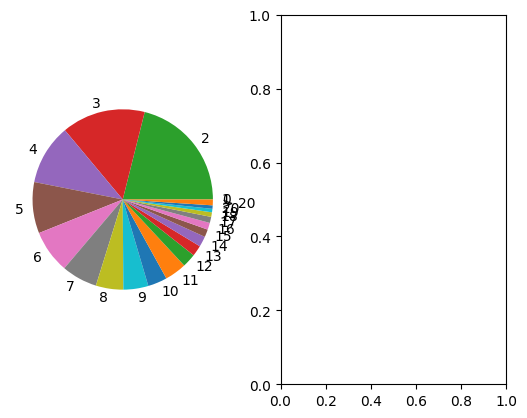

In [16]:
import matplotlib.pyplot as plt

pair_len_names = [str(i) for i in range(0, 22, 1)]
pair_len_names[-1] = "> 20"


fig, ax = plt.subplots(1,2)
ax[0].pie(lens, labels = pair_len_names)
plt.show()
# ax[0].pie(pair_lens_summarized, labels = pair_len_names)
# ax[1].pie(lens_summarized, labels = pair_len_names)

In [ ]:
import matplotlib.pyplot as plt

pair_lens_summarized = [0 for i in range(0, max(pair_lens), 50)]
lens_summarized = [0 for i in range(0, max(pair_lens), 50)]

pair_len_names = ["<" + str(i + 50) for i in range(0, max(pair_lens), 50)]

for pl in pair_lens:
    pair_lens_summarized[pl // 50] += pl
    lens_summarized[pl // 50] += 1

fig, ax = plt.subplots(1,2)

ax[0].pie(pair_lens_summarized, labels = pair_len_names)
ax[1].pie(lens_summarized, labels = pair_len_names)

In [28]:
from itertools import combinations
import random


def make_paired_id_dataset(id_dict, per_id_pair_num = 50):

    all_pairs = []
    for person_id, image_list in id_dict.items():
        if len(image_list) > 1:
            # print(image_list)
            possible_pairs = list(combinations(image_list, 2))
            pair_list = []

            while len(pair_list) < per_id_pair_num:
                pair_list += random.sample(possible_pairs, len(possible_pairs))
            
            pair_list = pair_list[:per_id_pair_num]
            
            # print(possible_pairs)
            # return possible_pairs
            # pair_lens.append(len(possible_pairs))
            all_pairs += pair_list
    
    return all_pairs
            # print(possible_pairs)
            # return possible_pairs

# for per_id_pair_num in range(10, 101, 10):
all_pairs = make_paired_id_dataset(id_dict, per_id_pair_num = 50)
    # len(make_paired_id_dataset(id_dict))
    # print(per_id_pair_num, len(all_pairs))

In [29]:
celeba_wild_dataset_list = [{"image0": raw_image0, "image1": raw_image1, "person_id": person_id, "text0": text0, "text1": text1}
    for (raw_image0, _, text0, _), (raw_image1, _, text1, _) in all_pairs
]
celeba_hq_dataset_list = [{"image0": aligned_hq_image0, "image1": aligned_hq_image1, "person_id": person_id, "text0": text0, "text1": text1}
    for (_, aligned_hq_image0, _, text0), (_, aligned_hq_image1, _, text1) in all_pairs
]

celeba_dataset_list = [{"image0_wild": raw_image0, "image1_wild": raw_image1, "person_id": person_id, "text0_wild": text0_wild, "text1_wild": text1_wild,
"image0_align": aligned_hq_image0, "image1_align": aligned_hq_image1,"text0_align": text0_align, "text1_align": text1_align}
    for (raw_image0, aligned_hq_image0, text0_wild, text0_align), (raw_image1, aligned_hq_image1, text1_wild, text1_align) in all_pairs
]


In [32]:
len(celeba_dataset_list)

225800

In [33]:
celeba_dataset_list# celeba_hq_dataset_list
celeba_hq_dataset_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/CelebAMask-HQ/dataset_celebahq_idpairs_200k.json"
celeba_wild_dataset_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/CelebA/dataset_celeba_wild_idpairs_200k.json"
celeba_full_dataset_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/CelebA/dataset_celeba_idpairs_200k.json"
with open(celeba_hq_dataset_path, "w") as f:
    json.dump(celeba_hq_dataset_list, f)
with open(celeba_wild_dataset_path, "w") as f:
    json.dump(celeba_wild_dataset_list, f)
with open(celeba_full_dataset_path, "w") as f:
    json.dump(celeba_dataset_list, f)

In [ ]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from utils.util import blip_cap
import pandas
import os
import torch
from PIL import Image
import pdb
from tqdm import tqdm
import json
file_mapping_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/CelebAMask-HQ/CelebA-HQ-to-CelebA-mapping.txt"
file_list = pandas.read_csv(file_mapping_path, delim_whitespace = True).values.tolist()


blip_processor = BlipProcessor.from_pretrained(
        "Salesforce/blip-image-captioning-large", local_files_only = True)
blip_model = BlipForConditionalGeneration.from_pretrained(
        "Salesforce/blip-image-captioning-large", torch_dtype=torch.float16, local_files_only = True).to("cuda")
# blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
# blip_model = Blip2ForConditionalGeneration.from_pretrained(
#     "Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16
# ).to("cuda")


celebahq_root = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/CelebAMask-HQ/CelebA-HQ-img"
celeba_root = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/CelebA/img_align_celeba"
celeba_wild_root = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/CelebA/img_celeba"

dataset_list = []


raw_image_list = []
aligned_hq_image_list = []
image_key_list = []

infer_batch_size = 16

image_prompts_dict = dict()



for i, (img_idx, orig_idx, orig_file) in enumerate(tqdm(file_list)):

    current_file = os.path.join(celebahq_root, f"{img_idx}.jpg")
    orig_wild_file = os.path.join(celeba_wild_root, orig_file)
    raw_image_list.append(Image.open(orig_wild_file))
    aligned_hq_image_list.append(Image.open(current_file))

    image_key_list.append(img_idx)

    if (i + 1) % infer_batch_size == 0 or i == len(file_list):
        raw_image_prompts = blip_cap(raw_image_list, blip_processor, blip_model)
        aligned_hq_image_prompts = blip_cap(aligned_hq_image_list, blip_processor, blip_model)

        image_prompts_dict.update(
            {
                image_idx: [raw_image_prompt, aligned_hq_image_prompt]
                for image_idx, raw_image_prompt, aligned_hq_image_prompt in 
                zip(image_key_list, raw_image_prompts, aligned_hq_image_prompts)
            }
        )
        raw_image_list = []
        aligned_hq_image_list = []
        image_key_list = []


with open("/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/CelebAMask-HQ/CelebAMask-HQ-prompts.json", "w") as f:
    json.dump(image_prompts_dict, f)


In [ ]:
import json
with open("/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/PascalVOC/VOC2012/depth_anything_v2_gray/val_dataset.json", "r") as f:
    a = json.load(f)
# a["2007_000346.jpg"]

In [ ]:

with open("/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/annotate/PascalVOC_val.json", "r") as f:
    b = json.load(f)

In [ ]:
path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/output_final/output_depth_lora_joint_gray_rank64_nta/eval_yad09"
cnt = 0
for item in b:
    
    ip = os.path.join(path, item)
    if not os.path.exists(ip):
        cnt += 1
print(cnt)
        # print(item)

In [ ]:
import os
path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/output_final/output_depth_lora_joint_gray_rank64_nta/eval_yad09"
for item in a:
    ip = os.path.join(path, item["file_name"])
    if not os.path.exists(ip):
        print(item)

In [ ]:
from utils.dataset import TrackDataset
from omegaconf import OmegaConf

config_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/svd-train/train_models/train_configs/track_dataset_val.yaml"
config = OmegaConf.load(config_path)
config = OmegaConf.to_container(config, resolve=True)
# train_dataset, train_dataloader = get_correspondence_loader(config, config["train_file"], True)

dataset = TrackDataset(**config)



In [1]:
from utils.dataset import PandaN

dataset_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/Panda70M/validation_videos.json"
# config = OmegaConf.load(config_path)
# config = OmegaConf.to_container(config, resolve=True)
# train_dataset, train_dataloader = get_correspondence_loader(config, config["train_file"], True)

dataset = PandaN(dataset_file = dataset_path)

/opt/conda/envs/jointdiff/lib/python3.9/site-packages/torchvision/datasets/video_utils.py:219: UserWarning: There aren't enough frames in the current video to get a clip for the given clip length and frames between clips. The video (and potentially others) will be skipped.
  warnings.warn(


length 363225
sample size 512


In [7]:
import glob
import os
dataset_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/Panda70M/validation"

video_files = glob.glob(os.path.join(dataset_path, "**", "*.mp4"))

In [8]:
import json
output_path = "/home/bml/storage/mnt/v-95c5b44cfcff4e6c/org/data_lxr/data/Panda70M/validation_videos.json"
with open(output_path, "w") as f:
    json.dump(video_files,f)